### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [131]:
import torch
import torch.nn as nn
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchtext
%matplotlib inline

In [132]:
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [133]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [134]:
data['FullDescription'][0]

'Engineering Systems Analyst Dorking Surrey Salary ****K Our client is located in Dorking, Surrey and are looking for Engineering Systems Analyst our client provides specialist software development Keywords Mathematical Modelling, Risk Analysis, System Modelling, Optimisation, MISER, PIONEEER Engineering Systems Analyst Dorking Surrey Salary ****K'

In [135]:
data.ContractType.unique()

array([nan, 'full_time', 'part_time'], dtype=object)

In [136]:
data.FullDescription[0]

'Engineering Systems Analyst Dorking Surrey Salary ****K Our client is located in Dorking, Surrey and are looking for Engineering Systems Analyst our client provides specialist software development Keywords Mathematical Modelling, Risk Analysis, System Modelling, Optimisation, MISER, PIONEEER Engineering Systems Analyst Dorking Surrey Salary ****K'

(array([8.18240e+04, 1.06594e+05, 3.91120e+04, 1.18100e+04, 5.13200e+03,
        9.60000e+01, 9.70000e+01, 5.60000e+01, 2.80000e+01, 1.90000e+01]),
 array([  5000.,  24500.,  44000.,  63500.,  83000., 102500., 122000.,
        141500., 161000., 180500., 200000.]),
 <BarContainer object of 10 artists>)

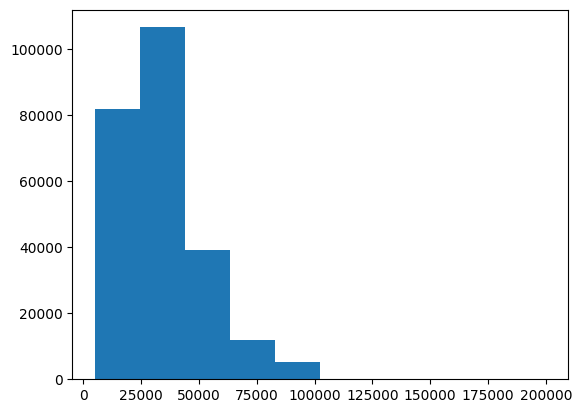

In [137]:
plt.hist(data['SalaryNormalized'])

In [138]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized'])

(array([  714.,  1138., 18622., 42467., 68697., 65041., 33935., 12601.,
         1444.,   109.]),
 array([ 8.51739317,  8.88626162,  9.25513007,  9.62399851,  9.99286696,
        10.36173541, 10.73060386, 11.0994723 , 11.46834075, 11.8372092 ,
        12.20607765]),
 <BarContainer object of 10 artists>)

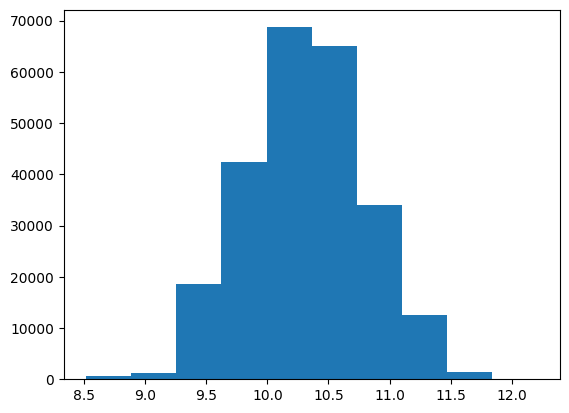

In [139]:
plt.hist(data['Log1pSalary'])

## RNN

In [140]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [141]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()

data['Title'] = data['Title'].apply(lambda sentence: ' '.join(tokenizer.tokenize(str(sentence).lower())))
data['FullDescription'] = data['FullDescription'].apply(lambda sentence: ' '.join(tokenizer.tokenize(str(sentence).lower())))

In [142]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total

for title in data['Title']:
    token_counts.update(title.split())

for title in data['FullDescription']:
    token_counts.update(title.split())

In [143]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count) #TODO<YOUR CODE HERE>

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [144]:
token_to_id = {w: i for i , w in enumerate(tokens)}

In [145]:
token_to_id

{'UNK': 0,
 'PAD': 1,
 '"': 2,
 '$': 3,
 '$****': 4,
 '$****$****': 5,
 '$****;': 6,
 '%': 7,
 '%)': 8,
 '%),': 9,
 '%).': 10,
 '%****': 11,
 '%,': 12,
 '%.': 13,
 '%/': 14,
 '%;': 15,
 '&': 16,
 '&****': 17,
 '&/': 18,
 "'": 19,
 "'&": 20,
 "''": 21,
 "')": 22,
 "').": 23,
 "'****": 24,
 "'****'": 25,
 "',": 26,
 "'.": 27,
 "';": 28,
 "'>": 29,
 "'>****": 30,
 "'>•": 31,
 "'?": 32,
 '(': 33,
 '($****': 34,
 '(%': 35,
 '(&': 36,
 "('": 37,
 '((': 38,
 '()': 39,
 '().': 40,
 '(****': 41,
 '(****%)': 42,
 '(****)': 43,
 '(****)(': 44,
 '(****)****': 45,
 '(****),': 46,
 '(****).': 47,
 '(********': 48,
 '(********)': 49,
 '(****/': 50,
 '(****/****': 51,
 '(****/****)': 52,
 '(****/****),': 53,
 '(****/****/****)': 54,
 '(****:': 55,
 '(****:****': 56,
 '(****:****)': 57,
 '(****:****:****)': 58,
 '(.': 59,
 '(>': 60,
 '(>****': 61,
 '(?)': 62,
 '(‘': 63,
 '(“': 64,
 ')': 65,
 ')&': 66,
 ")'": 67,
 ')(': 68,
 '))': 69,
 ')).': 70,
 ')****': 71,
 '),': 72,
 ').': 73,
 ').•': 74,
 ')/': 75

In [146]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [147]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,engineering systems analyst,engineering systems analyst dorking surrey sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,stress engineer glasgow,stress engineer glasgow salary **** to **** we...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,modelling and simulation analyst,mathematical modeller / simulation analyst / o...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986
3,12613049,engineering systems analyst / mathematical mod...,engineering systems analyst / mathematical mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk,10.221978
4,12613647,"pioneer , miser engineering systems analyst","pioneer , miser engineering systems analyst do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671


In [148]:
from sklearn.feature_extraction import DictVectorizer

categorical_columns = ['ContractTime','Company','Category']

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [149]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [150]:
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device


device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [151]:
class SalaryPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim, kernel_size=2),
            nn.BatchNorm1d(embedding_dim),
            nn.Dropout(0.2), 
            nn.ReLU(),
            nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim, kernel_size=2),
            nn.BatchNorm1d(embedding_dim),
            nn.ReLU(),
            nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim, kernel_size=2),
            nn.BatchNorm1d(embedding_dim),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
        )

        self.fc = nn.Linear(in_features = embedding_dim, out_features=1)

    def forward(self, batch):
        out = self.embedding(batch)
        out = torch.transpose(out,-1,-2)
        out = self.conv_layers(out)
        out = out.squeeze(-1)
        return self.fc(out)


In [154]:
from scipy import misc
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    """The training table dataset.
    """
    def __init__(self, dataframe):
        self.x_data = as_matrix(dataframe['Title'])
        self.y_data = dataframe['Log1pSalary']
        self.len = dataframe.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
        
    def __len__(self):
        return self.len

In [155]:
# DataLoader

batch_size = 64

train_dataset = CustomDataset(data_train)
val_dataset = CustomDataset(data_val)

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

model = SalaryPredictor(len(token_to_id),50)

model.to(device)

optim = torch.optim.Adam(model.parameters())

calc_loss = torch.nn.MSELoss()

In [161]:
import numpy as np
import time
import tqdm

def eval_model(model, data_generator):
    mse = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch).float().squeeze(-1) 
            loss = calc_loss(predictions,y_batch)
            mse.append(loss.to('cpu').numpy())
        return np.mean(mse)

            
def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        optimizer.zero_grad()

        # forward
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).float()
        predictions = model(X_batch).float().squeeze(-1)
        loss = calc_loss(predictions,y_batch).float() 

        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    train_loss_arr = []
    val_loss_arr = []

    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train_model(model, optimizer, train_data_generator)
        
        val_loss = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))

        train_loss_arr.append(train_loss)
        val_loss_arr.append(val_loss)
        plt.plot(range(epoch + 1), train_loss_arr, label = 'train')
        plt.plot(range(epoch + 1), val_loss_arr, label = 'val')
        plt.draw()
        plt.pause(0.1)

100%|██████████| 3060/3060 [00:12<00:00, 251.21it/s]


Epoch 1 of 30 took 13.392s
  training loss (in-iteration): 	0.101192


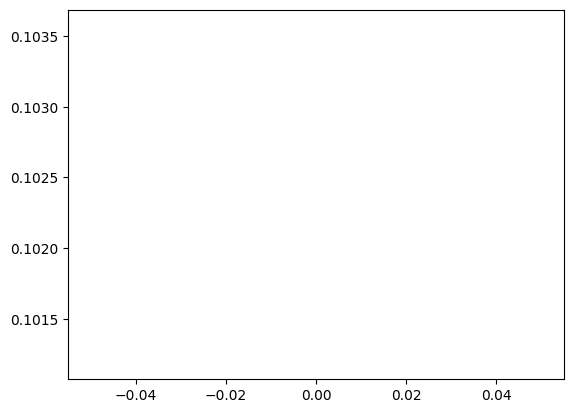

100%|██████████| 3060/3060 [00:12<00:00, 254.19it/s]


Epoch 2 of 30 took 13.222s
  training loss (in-iteration): 	0.096350


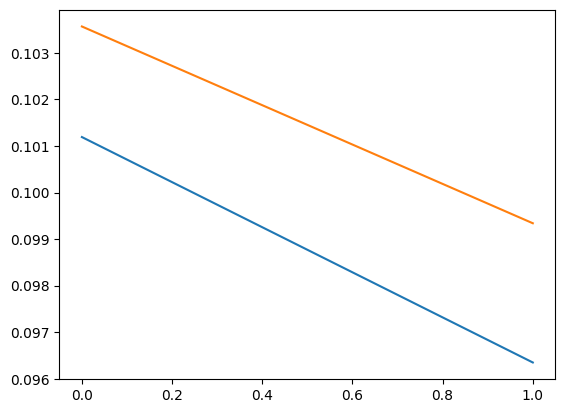

100%|██████████| 3060/3060 [00:12<00:00, 249.22it/s]


Epoch 3 of 30 took 13.478s
  training loss (in-iteration): 	0.092471


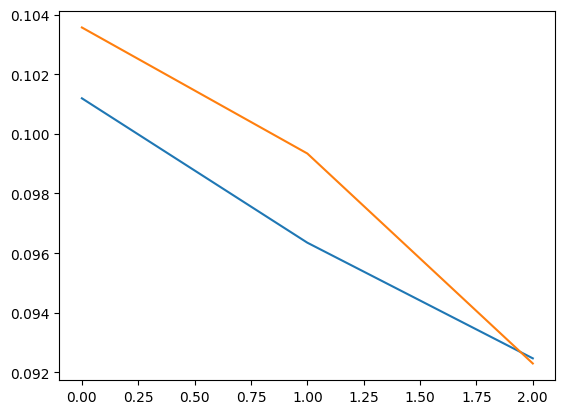

100%|██████████| 3060/3060 [00:12<00:00, 252.34it/s]


Epoch 4 of 30 took 13.337s
  training loss (in-iteration): 	0.089781


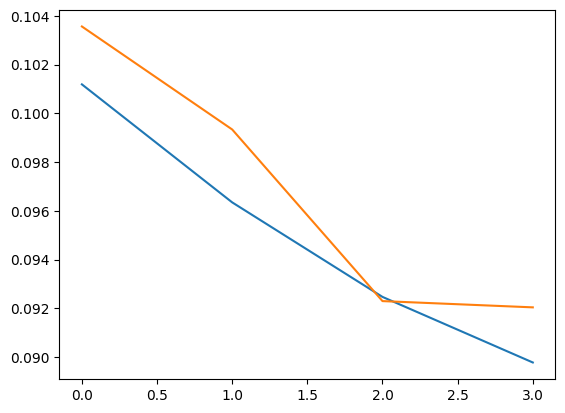

100%|██████████| 3060/3060 [00:12<00:00, 253.69it/s]


Epoch 5 of 30 took 13.265s
  training loss (in-iteration): 	0.087593


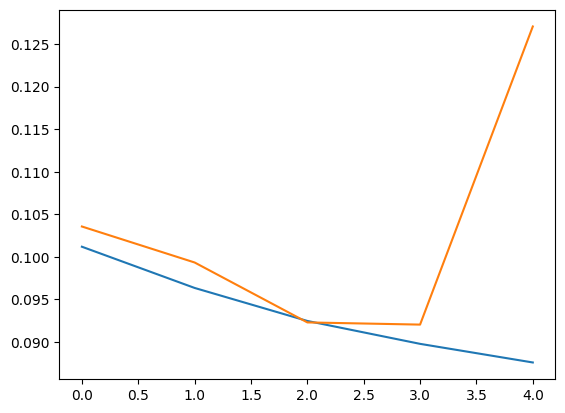

100%|██████████| 3060/3060 [00:12<00:00, 250.01it/s]


Epoch 6 of 30 took 13.455s
  training loss (in-iteration): 	0.085836


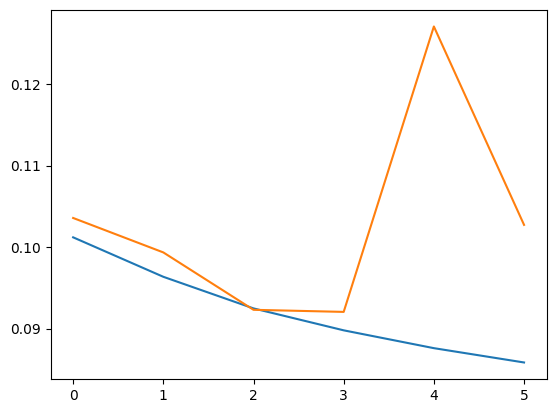

100%|██████████| 3060/3060 [00:12<00:00, 251.30it/s]


Epoch 7 of 30 took 13.394s
  training loss (in-iteration): 	0.083971


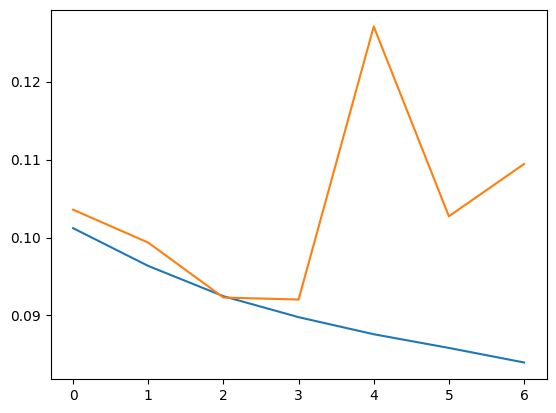

100%|██████████| 3060/3060 [00:12<00:00, 253.31it/s]


Epoch 8 of 30 took 13.265s
  training loss (in-iteration): 	0.082283


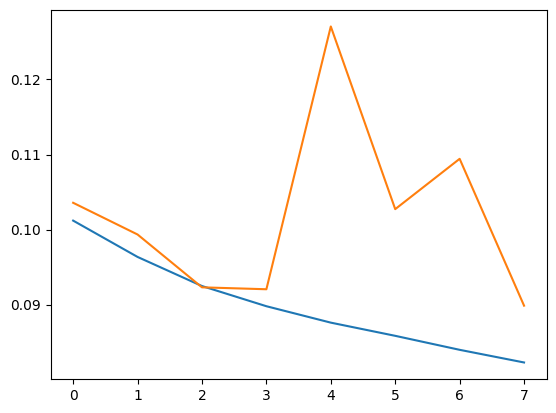

100%|██████████| 3060/3060 [00:12<00:00, 250.53it/s]


Epoch 9 of 30 took 13.429s
  training loss (in-iteration): 	0.081070


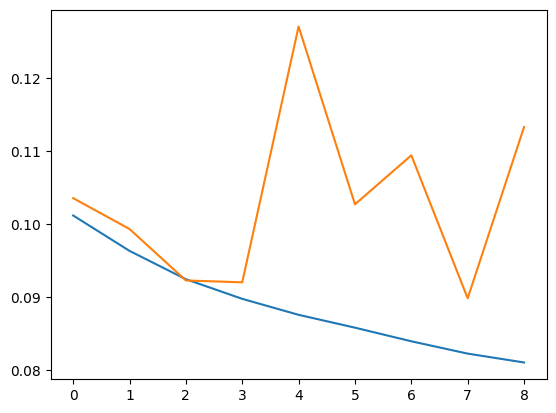

100%|██████████| 3060/3060 [00:12<00:00, 253.96it/s]


Epoch 10 of 30 took 13.277s
  training loss (in-iteration): 	0.079649


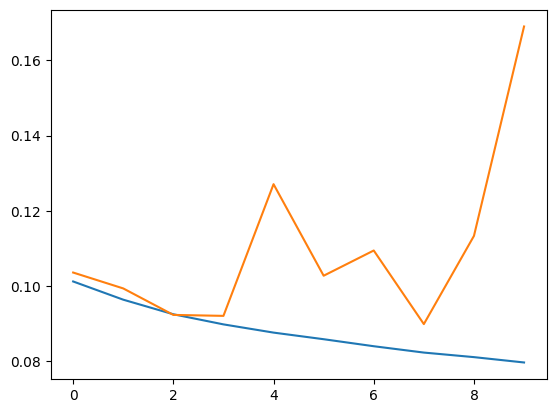

100%|██████████| 3060/3060 [00:12<00:00, 247.68it/s]


Epoch 11 of 30 took 13.575s
  training loss (in-iteration): 	0.079047


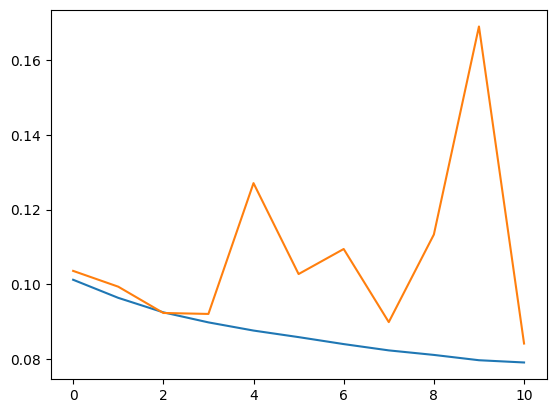

100%|██████████| 3060/3060 [00:12<00:00, 253.22it/s]


Epoch 12 of 30 took 13.285s
  training loss (in-iteration): 	0.077757


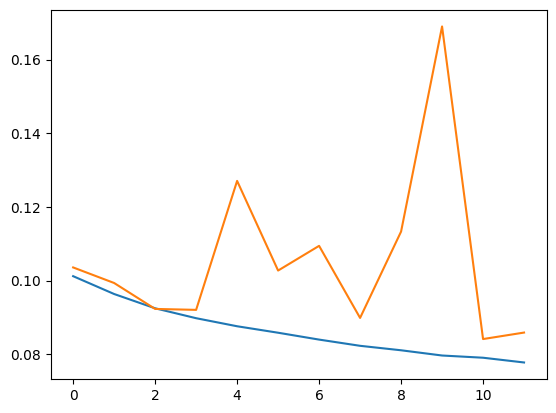

100%|██████████| 3060/3060 [00:11<00:00, 255.14it/s]


Epoch 13 of 30 took 13.187s
  training loss (in-iteration): 	0.076996


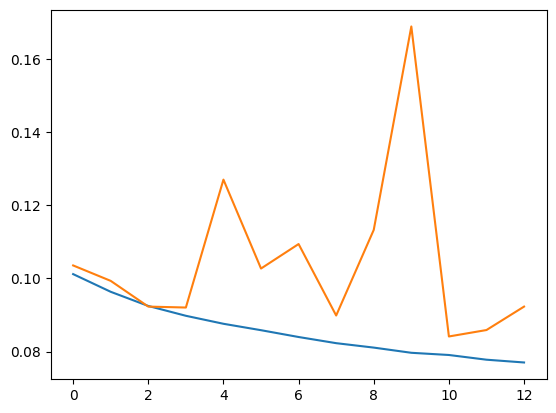

100%|██████████| 3060/3060 [00:11<00:00, 255.78it/s]


Epoch 14 of 30 took 13.165s
  training loss (in-iteration): 	0.075594


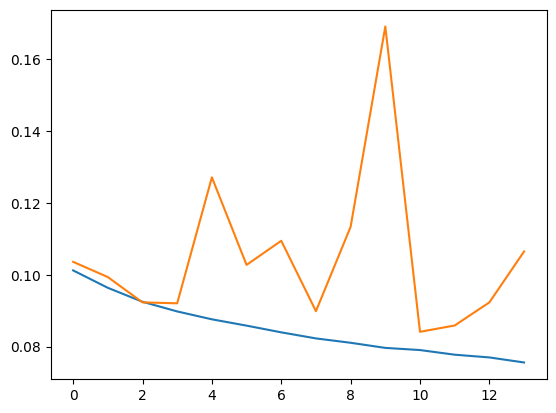

100%|██████████| 3060/3060 [00:12<00:00, 253.41it/s]


Epoch 15 of 30 took 13.274s
  training loss (in-iteration): 	0.074776


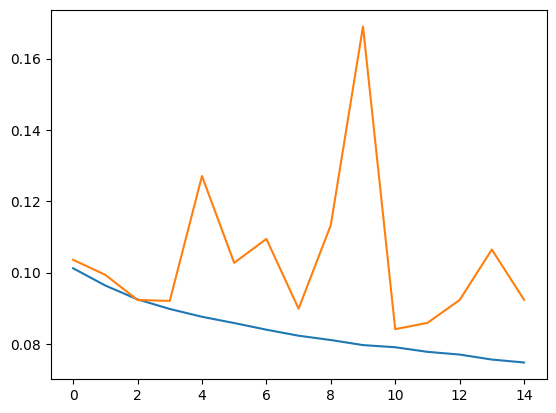

100%|██████████| 3060/3060 [00:12<00:00, 251.60it/s]


Epoch 16 of 30 took 13.355s
  training loss (in-iteration): 	0.073614


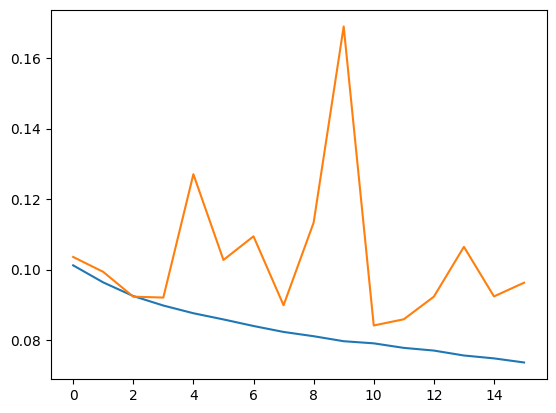

100%|██████████| 3060/3060 [00:11<00:00, 257.47it/s]


Epoch 17 of 30 took 13.066s
  training loss (in-iteration): 	0.073219


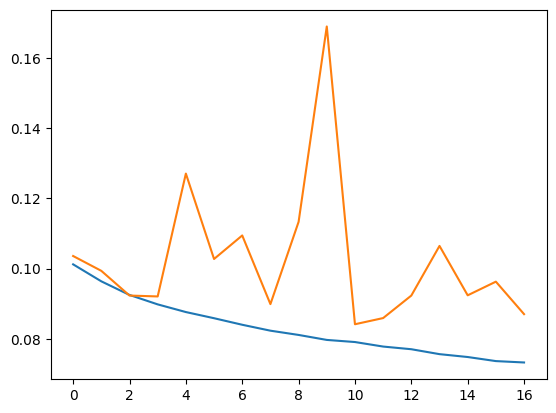

100%|██████████| 3060/3060 [00:11<00:00, 255.45it/s]


Epoch 18 of 30 took 13.161s
  training loss (in-iteration): 	0.072651


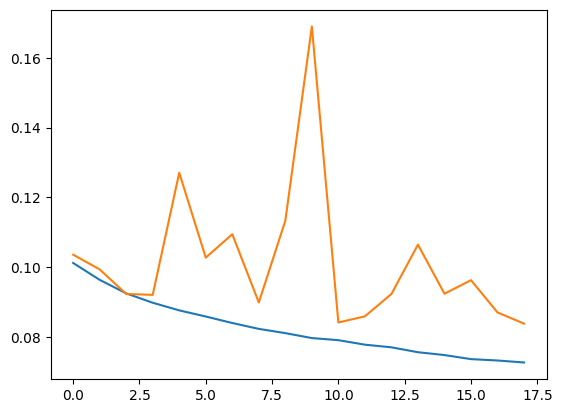

100%|██████████| 3060/3060 [00:11<00:00, 255.57it/s]


Epoch 19 of 30 took 13.175s
  training loss (in-iteration): 	0.071546


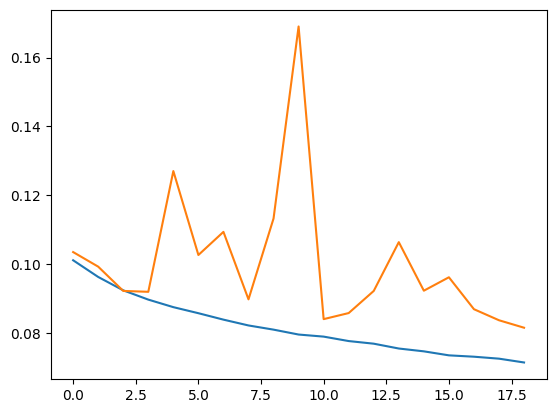

100%|██████████| 3060/3060 [00:11<00:00, 259.19it/s]


Epoch 20 of 30 took 12.980s
  training loss (in-iteration): 	0.071053


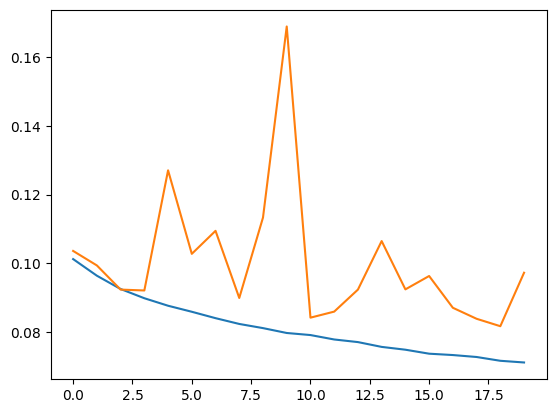

100%|██████████| 3060/3060 [00:12<00:00, 253.91it/s]


Epoch 21 of 30 took 13.285s
  training loss (in-iteration): 	0.070527


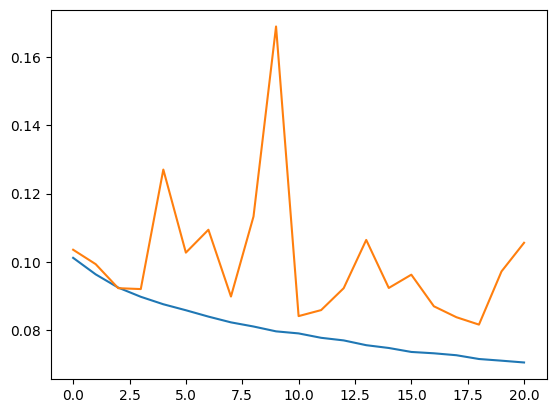

100%|██████████| 3060/3060 [00:12<00:00, 254.27it/s]


Epoch 22 of 30 took 13.235s
  training loss (in-iteration): 	0.069866


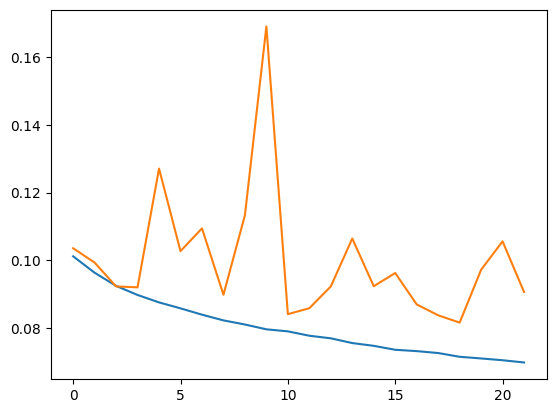

100%|██████████| 3060/3060 [00:11<00:00, 255.13it/s]


Epoch 23 of 30 took 13.181s
  training loss (in-iteration): 	0.069373


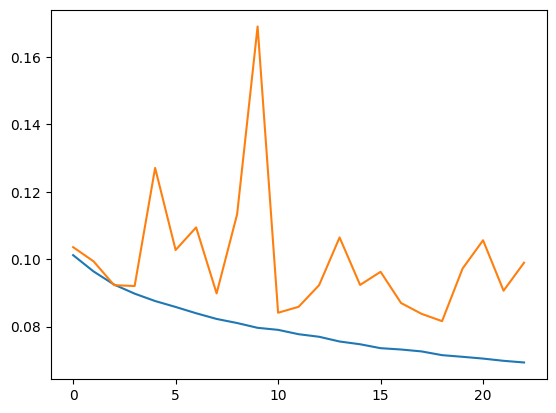

100%|██████████| 3060/3060 [00:11<00:00, 257.73it/s]


Epoch 24 of 30 took 13.050s
  training loss (in-iteration): 	0.068844


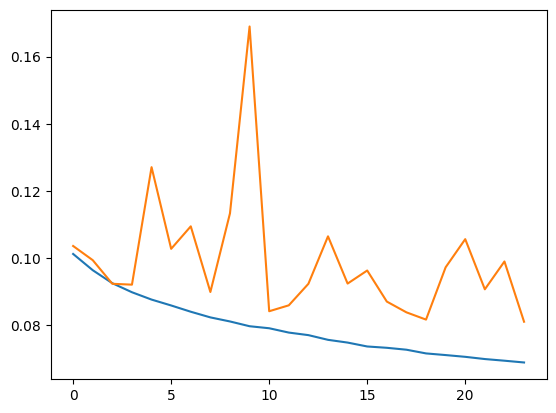

100%|██████████| 3060/3060 [00:11<00:00, 256.31it/s]


Epoch 25 of 30 took 13.127s
  training loss (in-iteration): 	0.068143


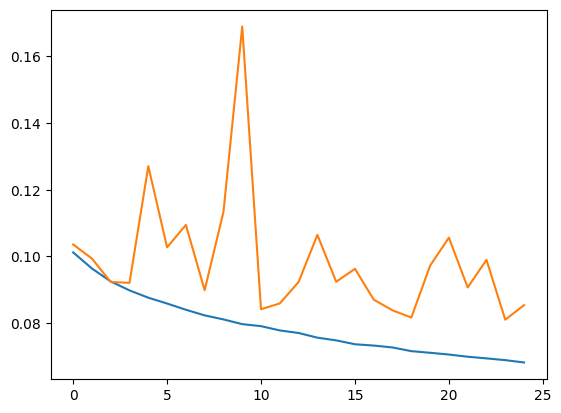

100%|██████████| 3060/3060 [00:12<00:00, 252.99it/s]


Epoch 26 of 30 took 13.312s
  training loss (in-iteration): 	0.068002


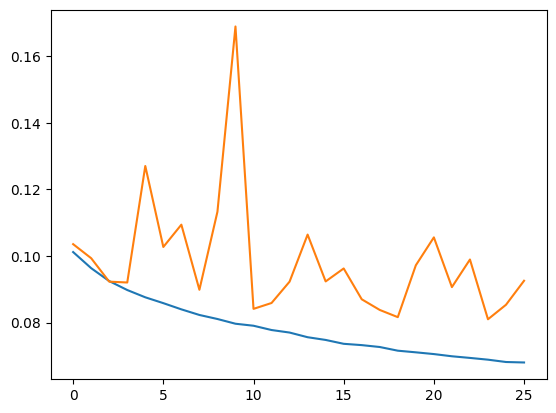

100%|██████████| 3060/3060 [00:12<00:00, 254.71it/s]


Epoch 27 of 30 took 13.196s
  training loss (in-iteration): 	0.067225


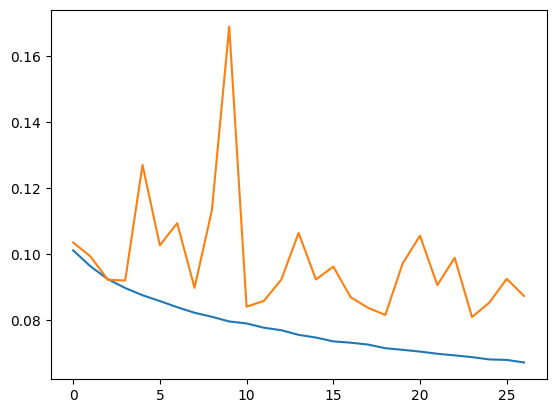

100%|██████████| 3060/3060 [00:11<00:00, 256.69it/s]


Epoch 28 of 30 took 13.092s
  training loss (in-iteration): 	0.066723


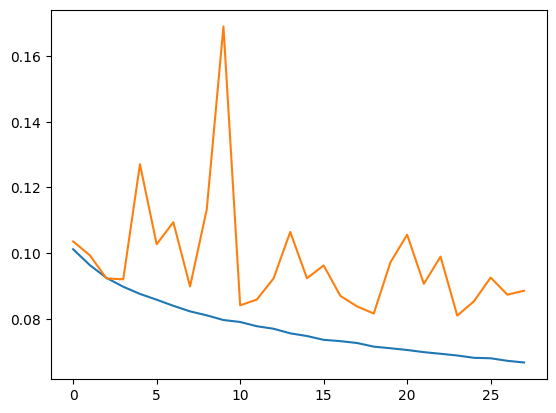

100%|██████████| 3060/3060 [00:11<00:00, 255.99it/s]


Epoch 29 of 30 took 13.134s
  training loss (in-iteration): 	0.066551


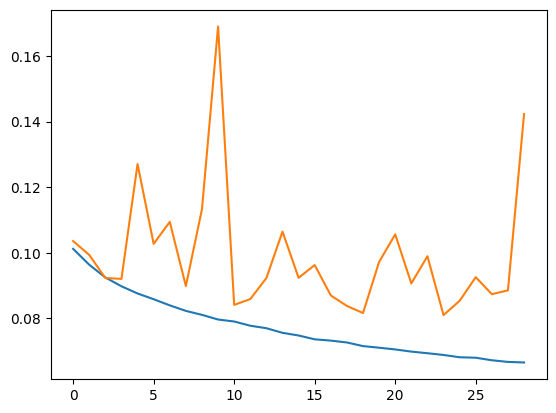

100%|██████████| 3060/3060 [00:11<00:00, 256.26it/s]


Epoch 30 of 30 took 13.114s
  training loss (in-iteration): 	0.065856


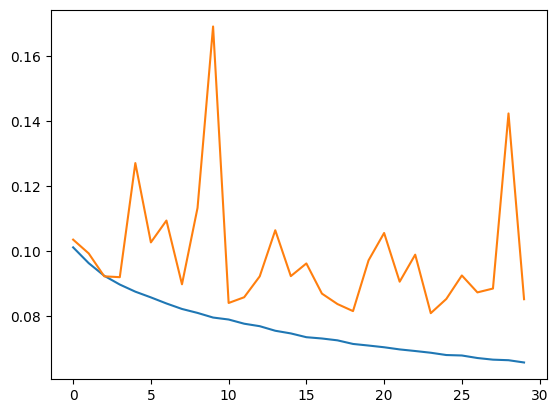

In [162]:
train_loop(model, optim, train_batch_gen, val_batch_gen, num_epochs=30)

In [182]:
X_test, y_test = next(iter(train_batch_gen))

predictions = model(X_test.to(device)).squeeze(-1)

label = predictions[6]

print(f'Predicted: {torch.exp(label) - 1}, Real: {torch.exp(y_test.to(device)[3]) - 1}')

Predicted: 44626.9140625, Real: 50000.000000000015


Predicted: 12600.1650390625, Real: 4944.667568785352


### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!